# Supervised outlier detection

In [1]:
import pymce as mce

import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA,TruncatedSVD,NMF,FastICA
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt
from matplotlib import gridspec
%matplotlib inline

## Defining clustering algorithm as clustering fucntion

In [2]:
agg = AgglomerativeClustering(n_clusters=2,
            affinity='euclidean', connectivity=None,
            compute_full_tree='auto', linkage='ward')

def clustering(z_mu):
    num = z_mu.shape[0]
    n_divide = int(num/4999)+1
    y = np.zeros(num)
    for inds in np.array_split(np.arange(num), n_divide):
        y[inds] = agg.fit_predict(z_mu[inds,:])
    return y

metrics = mce.metrics

## Signal synthesis

In [3]:
i_sig = 1
n_ftrs = 100
noise = 0.15
scl = 0.05
sft = 0.02

n_inlier_signals = 6
n_outlier_signals = 10

X_train, y_train = mce.synt_mix(i_sig,n_ftrs,n_sig=n_inlier_signals+1,sigma = noise,n1 = scl,n2 = sft,n3 = scl,n4 = sft)
X, y = mce.synt_mix(i_sig,n_ftrs,n_sig=n_outlier_signals+1,sigma = noise,n1 = scl,n2 = sft,n3 = scl,n4 = sft)

## Inliers (train set)

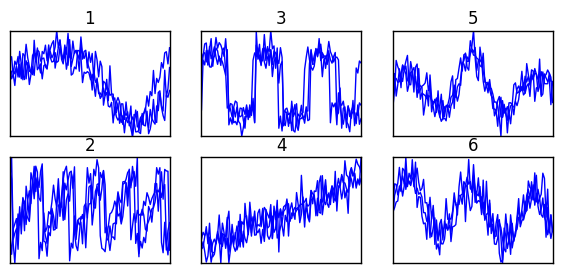

In [4]:
gs = gridspec.GridSpec(2, 3)
plt.figure(figsize=(7,3)) 

for i in range(n_inlier_signals):
    ax = plt.subplot(gs[i%2, i//2])
    ax.set_title(str(i+1))
    ax.set_xticks([])
    ax.set_yticks([])
    for j in range(3):
        xx = X_train[y_train==i+1][j]
        ax.plot(xx,'b')

## Inliers and outliers (test set)

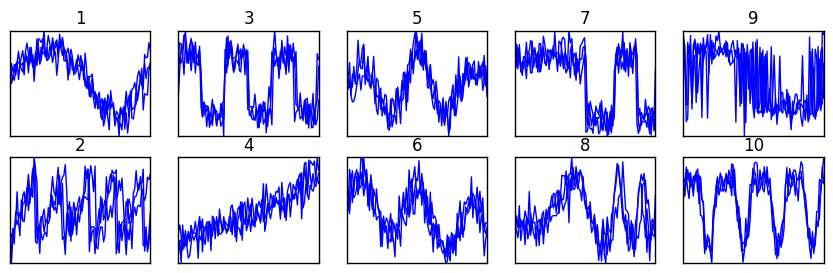

In [5]:
gs = gridspec.GridSpec(2, 5)
plt.figure(figsize=(10.5,3)) 

for i in range(n_outlier_signals):
    ax = plt.subplot(gs[i%2, i//2])
    ax.set_title(str(i+1))
    ax.set_xticks([])
    ax.set_yticks([])
    for j in range(3):
        xx = X[y==i+1][j]
        ax.plot(xx,'b')

## Outlier detection using autoencoders

In [6]:
nn_en = [n_ftrs, n_ftrs//2, 2]
nn_de = [2, n_ftrs//2, n_ftrs]
network_architecture = [nn_en,nn_de]

dim_rs ={'AE':'AE','VAE':'VAE'}

true_outliers = y>6

for dim_r, value in dim_rs.iteritems():
    
    print '---------------  '+dim_r+'  ----------------'

    # Splitter definition
    splitter = mce.Splitter(X_train, value, network_architecture, clustering)
    
    # Splitting
    splitter.split(3,verbose=0,training_epochs=20)
        
    # outlier extraction for all of requeste metrics
    outliers = mce.outliers(X,splitter,metrics)
        
    # ensembling
    ems_outliers = mce.norm_ensemble(outliers,0.1)
    
    # AUC
    auc = roc_auc_score(true_outliers, ems_outliers)

    print '{}: AUC={:4.2f}'.format(dim_r,auc)
        
    print '*********************************************'

---------------  AE  ----------------
AE: AUC=0.78
*********************************************
---------------  VAE  ----------------
VAE: AUC=0.82
*********************************************


## Outlier detection using Scikit-learn dimensionality reduction classes

In [7]:
dim_rs ={'PCA':PCA(n_components=2),
         'NMF':NMF(n_components=2), 
         'FastICA':FastICA(n_components=2, max_iter=1000)}

true_outliers = y>6

for dim_r, value in dim_rs.iteritems():
    
    print '---------------  '+dim_r+'  ----------------'

    # Splitter definition
    splitter = mce.Custom_Splitter(X_train, mce.sk_convert(value), clustering)

    # Splitting
    splitter.split(3,verbose=0)

    # outlier extraction for all of requeste metrics
    outliers = mce.outliers(X,splitter,metrics)
        
    # ensembling
    ems_outliers = mce.norm_ensemble(outliers,0.1)
    
    # AUC
    auc = roc_auc_score(true_outliers, ems_outliers)

    print '{}: AUC={:4.2f}'.format(dim_r,auc)
        
    print '*********************************************'

---------------  NMF  ----------------
NMF: AUC=0.99
*********************************************
---------------  PCA  ----------------
PCA: AUC=1.00
*********************************************
---------------  FastICA  ----------------
FastICA: AUC=0.88
*********************************************
